In [ ]:
!python3 -m pip install --upgrade statsmodels

In [36]:
%matplotlib inline

import numpy as np 
import pandas as pd 
import pylab as plt
import seaborn as sns
sns.set_style("whitegrid")

from IPython.display  import HTML
#import sweetviz

In [37]:
#machine learning libraries
import sklearn
from sklearn.metrics import pairwise_distances
#from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

import shapely

print(f'sklearn = {sklearn.__version__}')
print(f'pandas = {pd.__version__}')

sklearn = 1.0.2
pandas = 1.1.5


In [38]:
def createSimulatedDate(lenght):
    date = np.ceil(10*np.random.RandomState(seed=42).rand(lenght)).clip(1,10);
    date = date.astype(int)
    date = [f"2010-{i:02d}" for i in date];
    return pd.to_datetime(date);
    
    
df = (
    pd
    .read_csv('../Datasets/credit_card.csv')
    .rename(columns={'default.payment.next.month':'target','PAY_0':'PAY_1'})
    .assign(
        dt_ref=lambda x: createSimulatedDate(len(x)), #simulating datetime
        sample_id=lambda x: np.ceil(10*np.random.RandomState(seed=42).rand(len(x))).clip(1,10),
        isTrain=lambda x: x['sample_id'] < 7  #using hold out in a time frame
    )

)
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,target,dt_ref,sample_id,isTrain
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,689.0,0.0,0.0,0.0,0.0,1,2010-04-01,4.0,True
1,2,120000.0,2,2,2,26,-1,2,0,0,...,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1,2010-10-01,10.0,False
2,3,90000.0,2,2,2,34,0,0,0,0,...,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0,2010-08-01,8.0,False
3,4,50000.0,2,2,1,37,0,0,0,0,...,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0,2010-06-01,6.0,True
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0,2010-02-01,2.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000.0,1,3,1,39,0,0,0,0,...,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0,2010-10-01,10.0,False
29996,29997,150000.0,1,3,2,43,-1,-1,-1,-1,...,1837.0,3526.0,8998.0,129.0,0.0,0.0,0,2010-08-01,8.0,False
29997,29998,30000.0,1,2,2,37,4,3,2,-1,...,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1,2010-01-01,1.0,True
29998,29999,80000.0,1,3,1,41,1,-1,0,0,...,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1,2010-05-01,5.0,True


In [39]:
(
    df
    .describe(percentiles=[0.1,0.25,0.5,0.75,0.8,0.9])
    .T.drop(columns=['count'])
    .style.background_gradient(axis=1)
)

,mean,std,min,10%,25%,50%,75%,80%,90%,max
ID,15000.500000,8660.398374,1.000000,3000.900000,7500.750000,15000.500000,22500.250000,24000.200000,27000.100000,30000.000000
LIMIT_BAL,167484.322667,129747.661567,10000.000000,30000.000000,50000.000000,140000.000000,240000.000000,270000.000000,360000.000000,1000000.000000
SEX,1.603733,0.489129,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000
EDUCATION,1.853133,0.790349,0.000000,1.000000,1.000000,2.000000,2.000000,2.000000,3.000000,6.000000
MARRIAGE,1.551867,0.521970,0.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,3.000000
AGE,35.485500,9.217904,21.000000,25.000000,28.000000,34.000000,41.000000,43.000000,49.000000,79.000000
PAY_1,-0.016700,1.123802,-2.000000,-1.000000,-1.000000,0.000000,0.000000,1.000000,2.000000,8.000000
PAY_2,-0.133767,1.197186,-2.000000,-2.000000,-1.000000,0.000000,0.000000,0.000000,2.000000,8.000000
PAY_3,-0.166200,1.196868,-2.000000,-2.000000,-1.000000,0.000000,0.000000,0.000000,2.000000,8.000000
PAY_4,-0.220667,1.169139,-2.000000,-2.000000,-1.000000,0.000000,0.000000,0.000000,2.000000,8.000000


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 28 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ID         30000 non-null  int64         
 1   LIMIT_BAL  30000 non-null  float64       
 2   SEX        30000 non-null  int64         
 3   EDUCATION  30000 non-null  int64         
 4   MARRIAGE   30000 non-null  int64         
 5   AGE        30000 non-null  int64         
 6   PAY_1      30000 non-null  int64         
 7   PAY_2      30000 non-null  int64         
 8   PAY_3      30000 non-null  int64         
 9   PAY_4      30000 non-null  int64         
 10  PAY_5      30000 non-null  int64         
 11  PAY_6      30000 non-null  int64         
 12  BILL_AMT1  30000 non-null  float64       
 13  BILL_AMT2  30000 non-null  float64       
 14  BILL_AMT3  30000 non-null  float64       
 15  BILL_AMT4  30000 non-null  float64       
 16  BILL_AMT5  30000 non-null  float64      

In [41]:
def lag_indicator(df, min_=1,max_=7):
    for i in range(min_,max_):
        df['IU'+str(i)]= df['BILL_AMT'+str(i)] / df['LIMIT_BAL'];
        df['PER_PAYED'+str(i)]= df['PAY_AMT'+str(i)] / df['BILL_AMT'+str(i)]
        df['PER_PAYED'+str(i)] = df['PER_PAYED'+str(i)].replace([np.inf, -np.inf], np.nan).fillna(0);
    
    months = (6 - np.arange(6)).reshape(1,-1)
    #see if the IU and percent payed is increasing or decreasing with time, a.k.a, has correlation
    
    fields_per_payed = ['PER_PAYED'+str(i) for i in range(min_,max_)]
    df['TREND_PER_PAYED'] = 1- pairwise_distances(df[fields_per_payed],months,metric='correlation');
    df['TREND_PER_PAYED'] = df['TREND_PER_PAYED'].replace([np.inf, -np.inf], np.nan).fillna(0)

    fields_IU = ['IU'+str(i) for i in range(min_,max_)]
    df['TREND_PER_IU'] = 1- pairwise_distances(df[fields_IU],months,metric='correlation')
    df['TREND_PER_IU'] = df['TREND_PER_IU'].replace([np.inf, -np.inf], np.nan).fillna(0)
    return df;


df = (
    df
    .copy()
    .assign(
        SEX=lambda x:x['SEX'],  # Binarizing
        MARRIED=lambda x:x['MARRIAGE'].apply(lambda xx: 1 if xx == 1 else 0), # Binarizing
        
        #convert to years of study --- education == null ==> 0 years (worst case scenario)
        EDUCATION=lambda x:x['EDUCATION'].fillna(0).map({1:5,2:15, 3:9, 4:0, 5:0, 6:0, 0:0}), 
    )
    .pipe(lag_indicator)
)

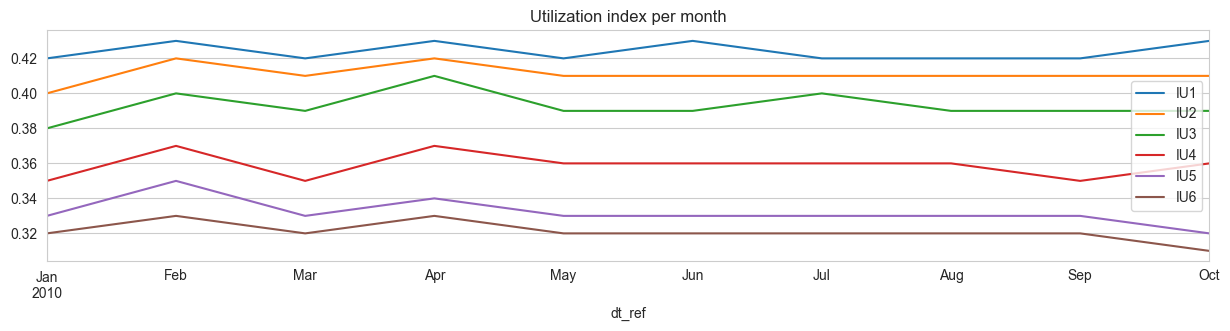

In [42]:
(
    df[['IU'+str(i) for i in range(1,7)] + ['dt_ref']]
    .groupby('dt_ref')
    .mean()
    .round(2)
    .plot(figsize=(15,3), title="Utilization index per month")
)

plt.legend(loc='best');
plt.grid(True);

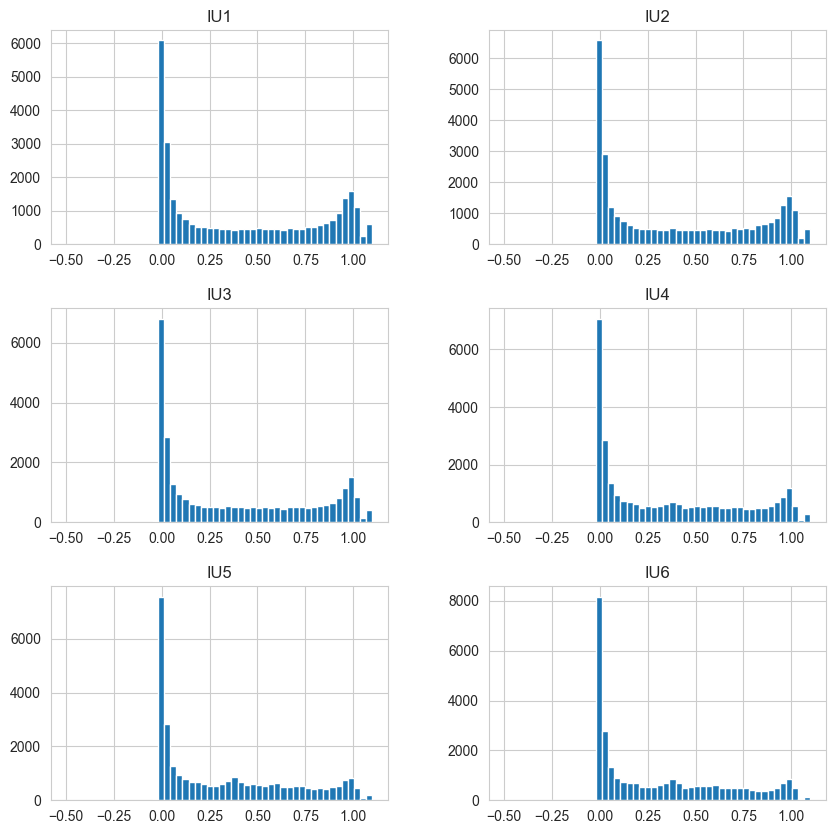

In [43]:
df[['IU'+str(i) for i in range(1,7)]].clip(-0.5,1.1).hist(bins=50, figsize=(10,10));

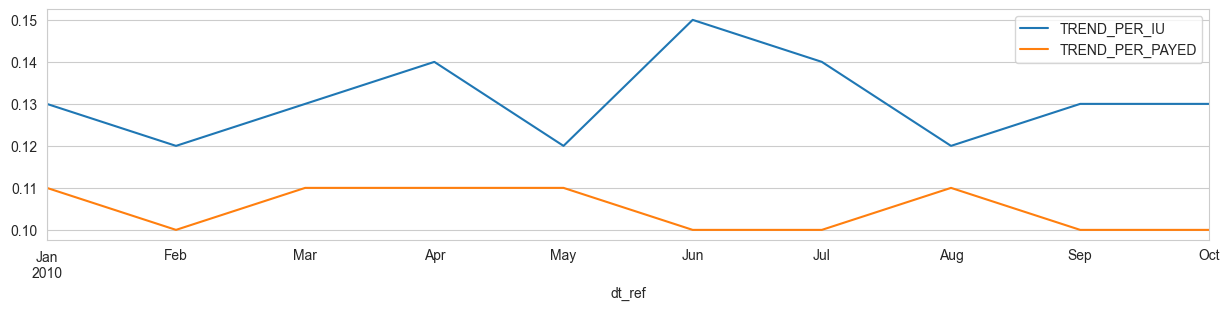

In [44]:
(
    df[['TREND_PER_IU','TREND_PER_PAYED'] + ['dt_ref']]
    .groupby('dt_ref')
    .mean()
    .round(2)
    .plot(figsize=(15,3))
)
plt.legend(loc='best');
plt.grid(True);

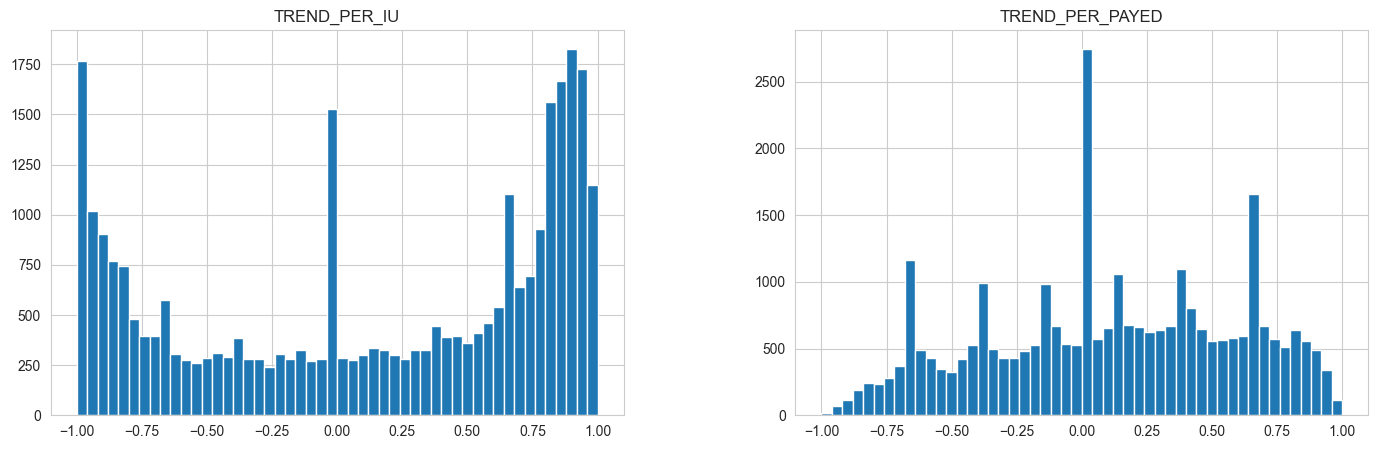

In [45]:
df[['TREND_PER_IU','TREND_PER_PAYED'] + ['dt_ref']].hist(bins=50, figsize=(17,5));

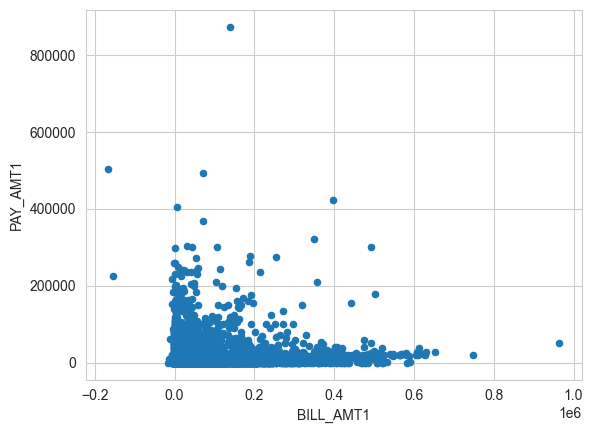

In [46]:
df.plot.scatter(x='BILL_AMT1',y='PAY_AMT1');

In [47]:
def EDA_continuous_v1(df, var,target='target', datetime='dt_ref', preprocess=None, hist_bins=100, figsize=(10,5)):
    display(HTML("EDA %s"%var))
    display(df[var].to_frame().describe(percentiles=np.linspace(0,1,11)).round(2).T)
    
    plt.figure(figsize=figsize);
    
    ### plot 1
    plt.subplot(121);
    plt.title(" Histogram - %s"%var);
    df[var].hist(bins=hist_bins, density=True);
    plt.xlabel(var);
    
    ### plot 2
    plt.subplot(122);
    temp =pd.DataFrame({        
        'rank': KBinsDiscretizer(n_bins=hist_bins, encode='ordinal').fit_transform(df[[var]]).flatten(),
        'rank_cluster': KBinsDiscretizer(n_bins=5,strategy='kmeans', encode='ordinal').fit_transform(df[[var]]).flatten(),
        var: preprocess(df[var].values) if preprocess is not None else df[var],
        target:df[target],
        datetime:df[datetime]
    })    
    sns.regplot(x=var,y=target,ax=plt.gca(), data=temp.groupby('rank').mean());
    
    plt.title("Correlation %0.4f" % temp.groupby('rank').mean().corr().values[0,1]);
    plt.tight_layout();
    plt.show();
    
    #plot 3
    plt.figure(figsize=(figsize[0],3))
    ax = plt.gca();
    temp.pivot_table(index=datetime, columns='rank_cluster',values=target).plot(ax=ax);
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), fancybox=True, shadow=True, ncol=10);
    ax.set_xlabel(datetime);
    ax.set_ylabel(f"Mean {target}");
    ax.set_title(f"{target} per cluster of {var} over time");
    plt.tight_layout();
    plt.show();
    
    display(
        temp
        .drop(columns=['rank_cluster'])
        .groupby('rank').mean()
        .style.background_gradient(axis=0)
    )

,count,mean,std,min,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%,max
AGE,18026.0,35.5,9.26,21.0,21.0,25.0,27.0,29.0,31.0,34.0,37.0,40.0,44.0,49.0,75.0,75.0


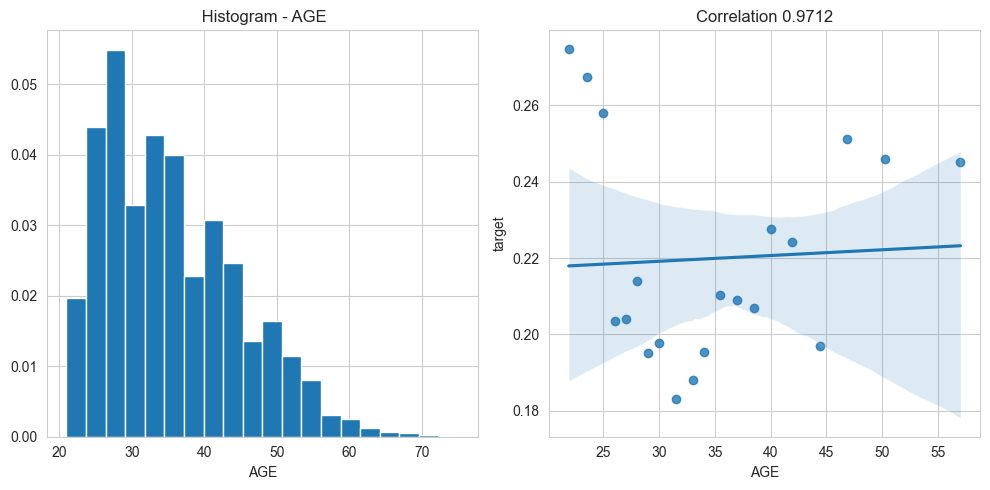

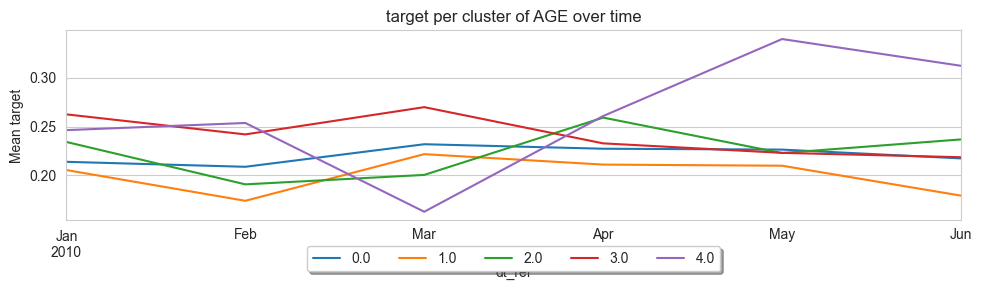

,AGE,target
rank,,
0.0,21.890585,0.274809
1.0,23.546334,0.267526
2.0,25.000000,0.257880
3.0,26.000000,0.203412
4.0,27.000000,0.204128
5.0,28.000000,0.213942
6.0,29.000000,0.195248
7.0,30.000000,0.197647
8.0,31.479972,0.183011


In [48]:
EDA_continuous_v1(df.query('sample_id < 7'),'AGE',hist_bins=20)

,count,mean,std,min,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%,max
TREND_PER_IU,18026.0,0.13,0.7,-1.0,-1.0,-0.91,-0.73,-0.38,0.0,0.27,0.58,0.75,0.85,0.92,1.0,1.0


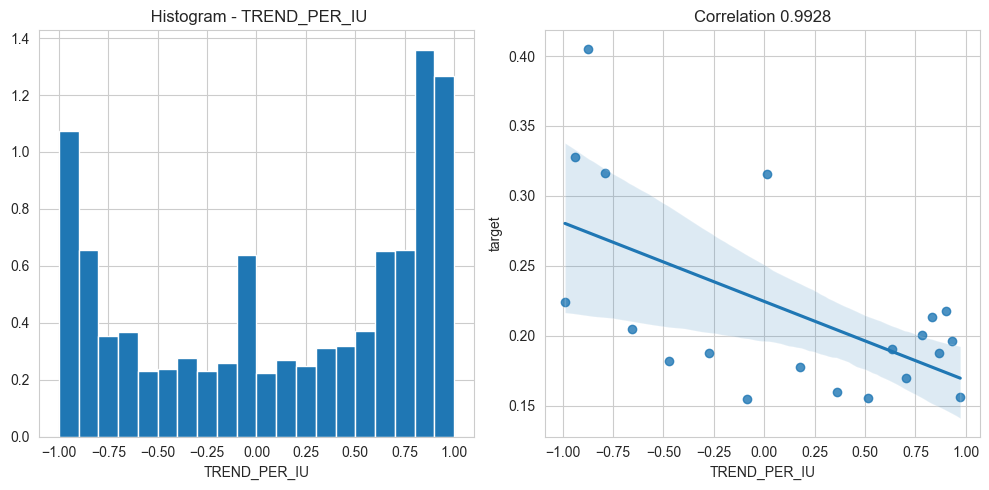

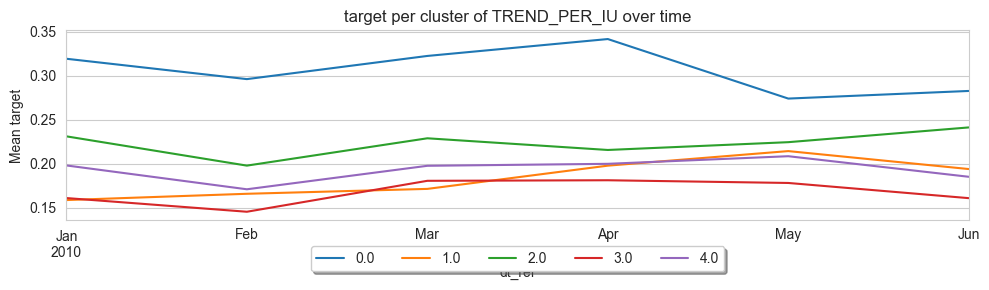

,TREND_PER_IU,target
rank,,
0.0,-0.988208,0.224195
1.0,-0.940186,0.328160
2.0,-0.875121,0.405105
3.0,-0.791638,0.316315
4.0,-0.656826,0.205100
5.0,-0.472348,0.182020
6.0,-0.273858,0.187569
7.0,-0.086120,0.154873
8.0,0.011870,0.315939


In [49]:
EDA_continuous_v1(df.query('sample_id < 7'),'TREND_PER_IU',hist_bins=20)

,count,mean,std,min,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%,max
TREND2_PER_PAYED,18026.0,0.59,0.27,0.0,0.0,0.21,0.34,0.39,0.51,0.61,0.69,0.8,0.87,0.97,1.0,1.0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


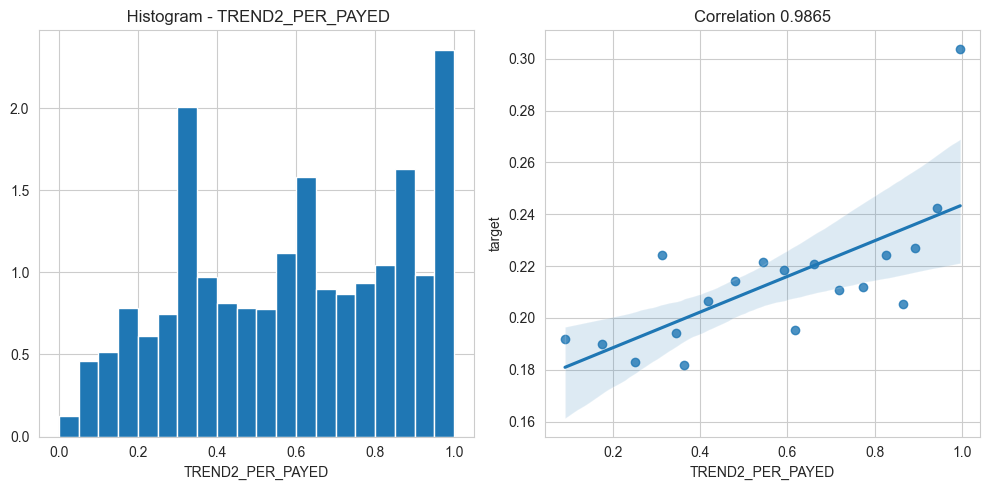

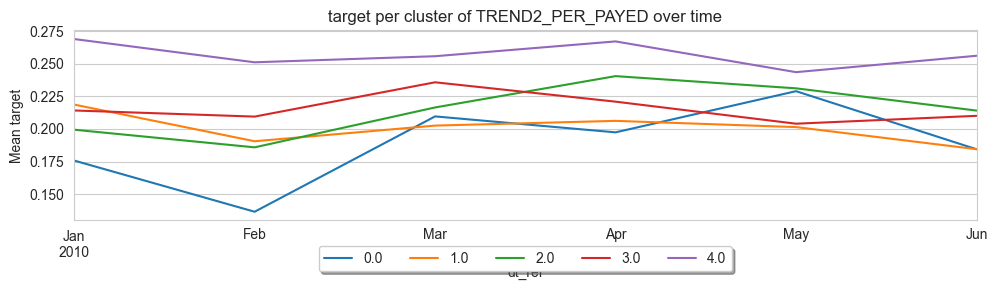

,TREND2_PER_PAYED,target
rank,,
0.0,0.090506,0.191796
1.0,0.175214,0.189789
2.0,0.249735,0.183130
3.0,0.313456,0.224195
4.0,0.344209,0.194229
5.0,0.362897,0.181818
6.0,0.417766,0.206437
7.0,0.480097,0.214206
8.0,0.543165,0.221729


In [50]:
#applying the transformation seen above that make the relationship more linear
df['TREND2_PER_PAYED'] = 1-np.abs(df['TREND_PER_PAYED'].values)
EDA_continuous_v1(df.query('sample_id < 7'),'TREND2_PER_PAYED',hist_bins=20) # trend2 contains the intensity of the direction

,count,mean,std,min,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%,max
AGE,18026.0,35.5,9.26,21.0,21.0,25.0,27.0,29.0,31.0,34.0,37.0,40.0,44.0,49.0,75.0,75.0


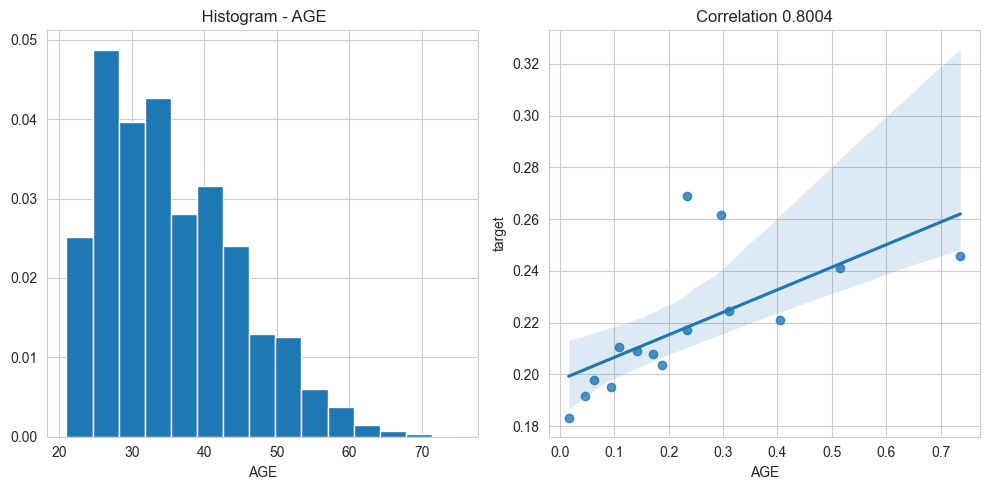

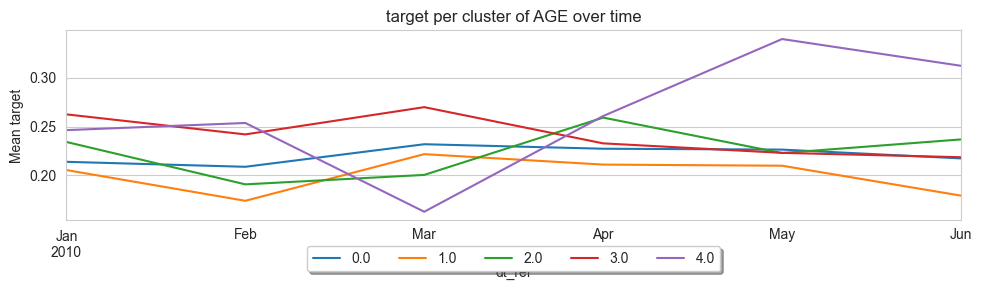

,AGE,target
rank,,
0.0,0.295502,0.261506
1.0,0.234148,0.268895
2.0,0.187500,0.203412
3.0,0.140992,0.208920
4.0,0.093750,0.195248
5.0,0.062500,0.197647
6.0,0.016251,0.183011
7.0,0.046807,0.191643
8.0,0.109108,0.210409


In [51]:
EDA_continuous_v1(df.query('sample_id < 7'),'AGE', preprocess=lambda x: abs(x-32)/32,hist_bins=15) # how far you are from 32yo. / 32 is when the parabole changes upward again

In [52]:
df['AGE_NORM'] = np.abs(df['AGE']-32)/32

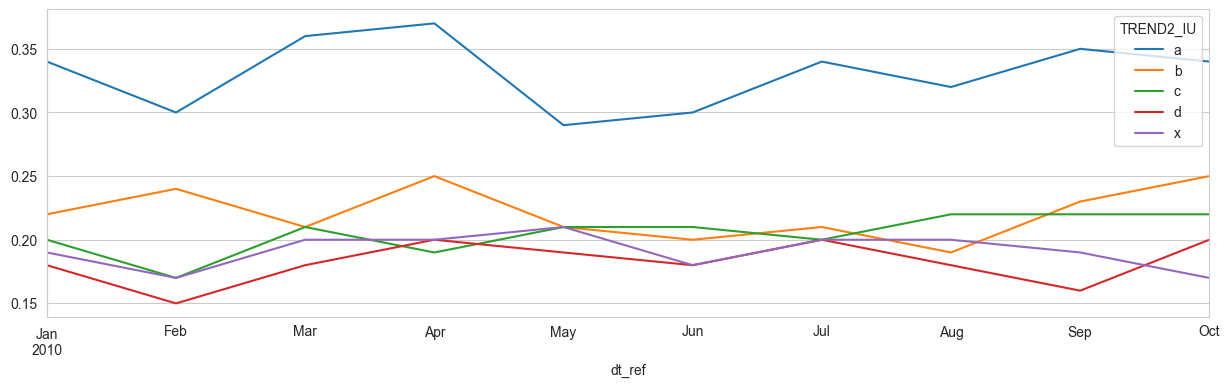

In [53]:
def temp(x):
    if x < -0.8:
        return 'a';
    elif x < -0.5:
        return 'b';
    elif x < 0.5:
        return 'c';
    elif x < 0.8:
        return 'd';
    else:
        return 'x';

df['TREND2_IU']=df['TREND_PER_IU'].apply(temp)
(
    df
    .pivot_table(index='dt_ref',columns='TREND2_IU',values='target')
    .round(2)
    .plot(figsize=(15,4))
);

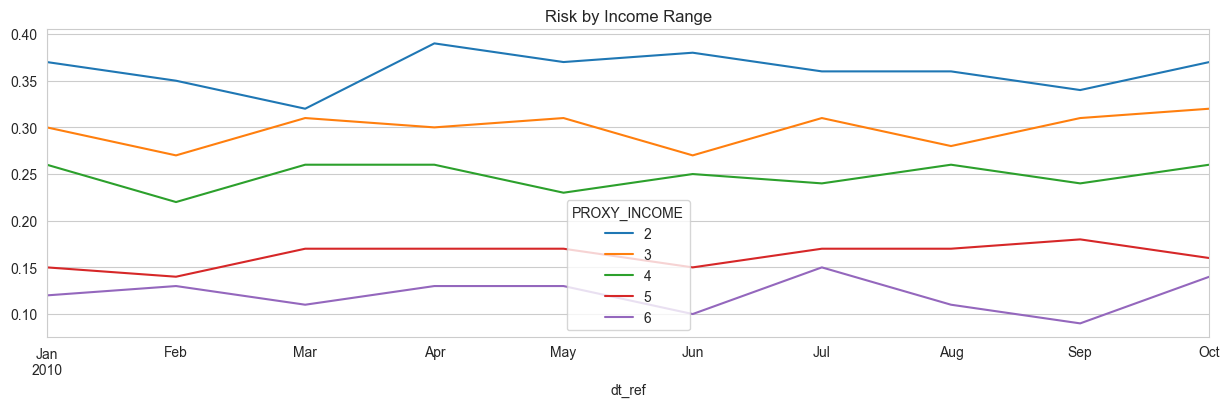

In [54]:
def income2Range(x):
    # income are generaly exponential.
    x = x/1000;
    
    return str(int(np.log(x)))

# Assuming the limit gave to the client has to something to do with his income.
# in the practice the risk + income defines the limit. So in the real world using the limit as input would break your model. 
df['PROXY_INCOME']=df['LIMIT_BAL'].apply(income2Range)
(
    df
    .pivot_table(index='dt_ref',columns='PROXY_INCOME',values='target')
    .round(2)
    .plot(figsize=(15,4), title='Risk by Income Range')
);

display(HTML("We can see that different limits/incomes has different risks"))

In [55]:
def model_report(df, query_test, target='target',prob='prob', time_id='dt_ref'):
    def model_stats(x):
        s = pd.Series({
            'prob':x[prob].mean(),
            target:x[target].mean(),
            'count':len(x),
            'event':x[target].sum(),
            'non_event': len(x) - x[target].sum()
        });
        return s

    temp = (
        df.query(query_test)
        .groupby('score').apply(model_stats).round(2)
        .assign(per_count=lambda x:x['count'] / x['count'].sum())
        .assign(per_event=lambda x:x['event'] / x['event'].sum())
        .assign(non_per_event=lambda x:x['non_event'] / x['non_event'].sum())
        .assign(odds=lambda x:x['per_event']/x['non_per_event'])
        .assign(per_pop_acc=lambda x:x['count'].cumsum()/x['count'].sum())
        .assign(per_event_acc=lambda x:x['event'].cumsum()/x['event'].sum())
        .assign(lift=lambda x:x[target] / ( x['event'].sum()/ x['count'].sum()))
    );
    
    display(temp.reset_index().round(2))
    temp_total = temp.mean();
    display(temp_total.to_frame().T.round(2))

    plt.figure(figsize=(12,8))
    plt.subplot(221);
    temp.plot.scatter(x='prob',y=target,ax=plt.gca());
    plt.xlabel('Prob');
    plt.xlabel('Mean target');

    plt.subplot(222);
    plt.title('Strategy plot')
    temp[['per_pop_acc','per_event_acc']].plot(ax=plt.gca());
    plt.grid();
    #print(temp.reset_index().columns)
    
    plt.subplot(223);
    plt.title('KS %0.2f'% np.abs( temp['per_event'].cumsum() -temp['non_per_event'].cumsum()).max())
    temp.reset_index().plot.bar(x='prob',y=['per_event','non_per_event'],ax=plt.gca());
    
    #ROC
    fpr, tpr, _ = roc_curve(df[target],df[prob])
    roc_auc = auc(fpr, tpr)
    
    plt.subplot(224);
    plt.plot(fpr, tpr, color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc);
    plt.plot([0, 1], [0, 1], color='navy',  linestyle='--');
    plt.xlim([0.0, 1.0]);
    plt.ylim([0.0, 1.05]);
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate');
    plt.title('ROC curve');
    plt.legend(loc="lower right");
    plt.tight_layout();
    plt.show();
    
    
    # stability 
    plt.figure(figsize=(12,4), tight_layout=True)
    plt.subplot(121);
    df_score = df.pivot_table(index=time_id,columns='score',values=target);
    df_score.plot(ax=plt.gca());
    plt.title("Score stability");
    
    plt.subplot(122);
    df.pivot_table(
        index=time_id,
        columns='score',
        values=target,
        aggfunc='count').plot(ax=plt.gca(), kind='bar', stacked=True)
    plt.title("Score stability");
    plt.show();
    
    from scipy import stats;
    
    scores = np.sort(df['score'].unique());
    test = []
    for i in range(len(scores)-1):
        test.append({
            'score_1':i,
            'score_2':i+1,
            #'ks_normal_test_score_1': round(stats.kstest(df_score[scores[i]],'norm')[0],5),
            'p_value_test':round(stats.ttest_rel(df_score[scores[i]], df_score[i+1])[1],5),
            'cv_1': stats.variation(df_score[scores[i]]),
            'per_invertion': (df_score[scores[i]] > df_score[scores[i+1]]).mean(),
        })
        
    display(pd.DataFrame(test))

In [56]:
def createCluster(df, n_bins=10, train_query='sample_id < 7'):
    binner = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='kmeans')
    binner.fit(df.query(train_query)[['prob']])
    return binner.transform(df[['prob']])

In [57]:
import statsmodels.api as sm
from statsmodels.formula.api import logit

# suggested variables - feel free to change
vars = [
    'PROXY_INCOME',
    'TREND2_IU',
    'TREND_PER_PAYED' ,
    'SEX',
    'MARRIED',
    'IU1',
    'AGE_NORM'
];

df2 = df.copy().replace([np.inf, -np.inf], np.nan).fillna(0);

logit_mod = logit('target ~ ' + (' + '.join(vars)), df2.query('sample_id < 7'))
logit_res = logit_mod.fit(disp=0)
display(logit_res.summary())
    
df = (
    df.assign(
        prob=logit_res.predict(df2),
        score=lambda x:createCluster(x, n_bins=7)
    )
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                18026
Model:                          Logit   Df Residuals:                    18012
Method:                           MLE   Df Model:                           13
Date:                Wed, 12 Apr 2023   Pseudo R-squ.:                 0.04391
Time:                        11:45:54   Log-Likelihood:                -9049.7
converged:                       True   LL-Null:                       -9465.4
Covariance Type:            nonrobust   LLR p-value:                2.684e-169
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.1566      0.097     -1.621      0.105      -0.346       0.033
PROXY_INCOME[T.3]    -0.2780      0.069     -4.058      0.000      -0.412      -0.144
PROXY_INCOME[T.4]    -0.4786      0.067     -7.145      0.000      -0.610      -0.347
PROXY_INCOME[T.5]    -0.9381      0.068    -13.826      0.000      -1.071      -0.805
PROXY_INCOME[T.6]    -1.3030      0.113    -11.543      0.000      -1.524      -1.082
TREND2_IU[T.b]       -0.4443      0.072     -6.202      0.000      -0.585      -0.304
TREND2_IU[T.c]       -0.5074      0.054     -9.450      0.000      -0.613      -0.402
TREND2_IU[T.d]       -0.7792      0.063    -12.384      0.000      -0.903      -0.656
TREND2_IU[T.x]       -0.8493      0.059    -14.464      0.000      -0.964      -0.734
TREND_PER_PAYED      -0.2346      0.040     -5.862      0.000      -0.313      -0.156
SEX                  -0.1536      0.038     -4.060      0.000      -0.228      -0.079
MARRIED               0.1989      0.039      5.134      0.000       0.123       0.275
IU1                   0.3569      0.054      6.632      0.000       0.251       0.462
AGE_NORM              0.1562      0.096      1.634      0.102      -0.031       0.344
=====================================================================================
"""

,score,prob,target,count,event,non_event,per_count,per_event,non_per_event,odds,per_pop_acc,per_event_acc,lift
0,0.0,0.12,0.13,2525.0,317.0,2208.0,0.21,0.12,0.24,0.49,0.21,0.12,0.58
1,1.0,0.16,0.18,2829.0,504.0,2325.0,0.24,0.19,0.25,0.75,0.45,0.30,0.80
2,2.0,0.21,0.21,2302.0,472.0,1830.0,0.19,0.18,0.20,0.89,0.64,0.48,0.93
3,3.0,0.26,0.25,1875.0,474.0,1401.0,0.16,0.18,0.15,1.16,0.80,0.66,1.11
4,4.0,0.32,0.33,1268.0,424.0,844.0,0.11,0.16,0.09,1.73,0.90,0.81,1.47
5,5.0,0.38,0.41,804.0,330.0,474.0,0.07,0.12,0.05,2.40,0.97,0.94,1.82
6,6.0,0.46,0.47,371.0,175.0,196.0,0.03,0.06,0.02,3.07,1.00,1.00,2.09


,prob,target,count,event,non_event,per_count,per_event,non_per_event,odds,per_pop_acc,per_event_acc,lift
0,0.27,0.28,1710.57,385.14,1325.43,0.14,0.14,0.14,1.5,0.71,0.61,1.26


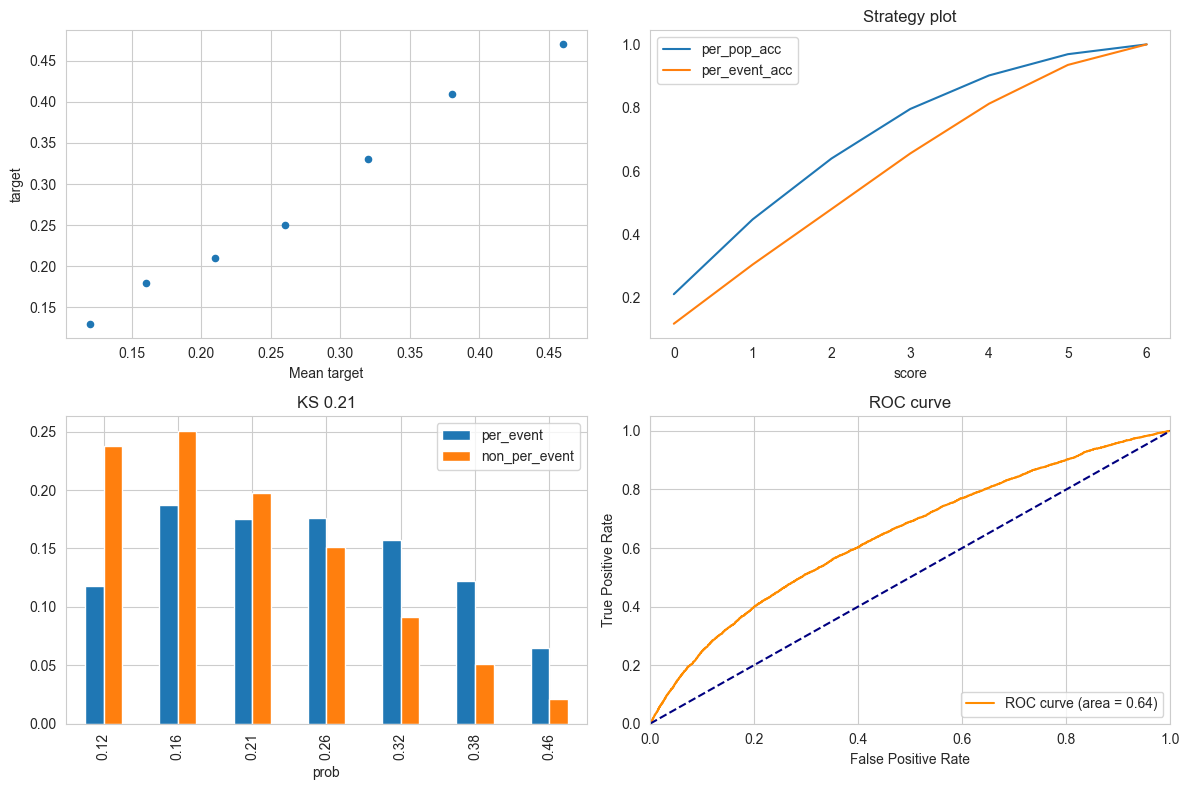

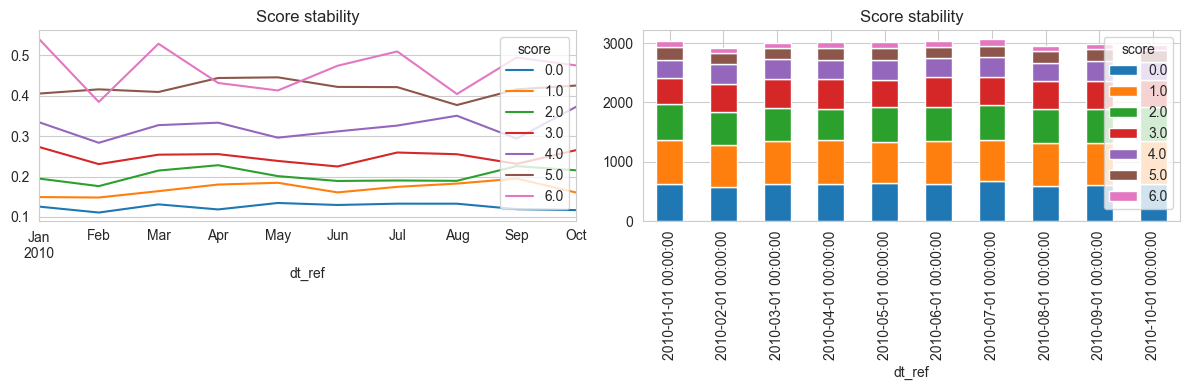

,score_1,score_2,p_value_test,cv_1,per_invertion
0,0,1,0.00001,0.062376,0.0
1,1,2,0.00016,0.088202,0.0
2,2,3,0.00008,0.082096,0.0
3,3,4,0.00000,0.062266,0.0
4,4,5,0.00002,0.080539,0.0
5,5,6,0.03299,0.044328,0.3


In [58]:
model_report(df,'sample_id >= 7 ')

In [59]:
df2 = df.copy().replace([np.inf, -np.inf], np.nan).fillna(0);

# creating the dummies manually
dummy = pd.get_dummies(df[['PROXY_INCOME','TREND2_IU']],drop_first=True,prefix=['PROXY_INCOME','TREND2_IU'])
df2 = pd.concat([
    df,
    dummy
], axis=1)

vars = [
    'SEX',
    'MARRIED',
    'TREND_PER_PAYED' ,
    'IU1',
] + dummy.columns.tolist()

,score,prob,target,count,event,non_event,per_count,per_event,non_per_event,odds,per_pop_acc,per_event_acc,lift
0,0.0,0.12,0.13,2525.0,317.0,2208.0,0.21,0.12,0.24,0.49,0.21,0.12,0.58
1,1.0,0.16,0.18,2829.0,504.0,2325.0,0.24,0.19,0.25,0.75,0.45,0.30,0.80
2,2.0,0.21,0.21,2302.0,472.0,1830.0,0.19,0.18,0.20,0.89,0.64,0.48,0.93
3,3.0,0.26,0.25,1875.0,474.0,1401.0,0.16,0.18,0.15,1.16,0.80,0.66,1.11
4,4.0,0.32,0.33,1268.0,424.0,844.0,0.11,0.16,0.09,1.73,0.90,0.81,1.47
5,5.0,0.38,0.41,804.0,330.0,474.0,0.07,0.12,0.05,2.40,0.97,0.94,1.82
6,6.0,0.46,0.47,371.0,175.0,196.0,0.03,0.06,0.02,3.07,1.00,1.00,2.09


,prob,target,count,event,non_event,per_count,per_event,non_per_event,odds,per_pop_acc,per_event_acc,lift
0,0.27,0.28,1710.57,385.14,1325.43,0.14,0.14,0.14,1.5,0.71,0.61,1.26


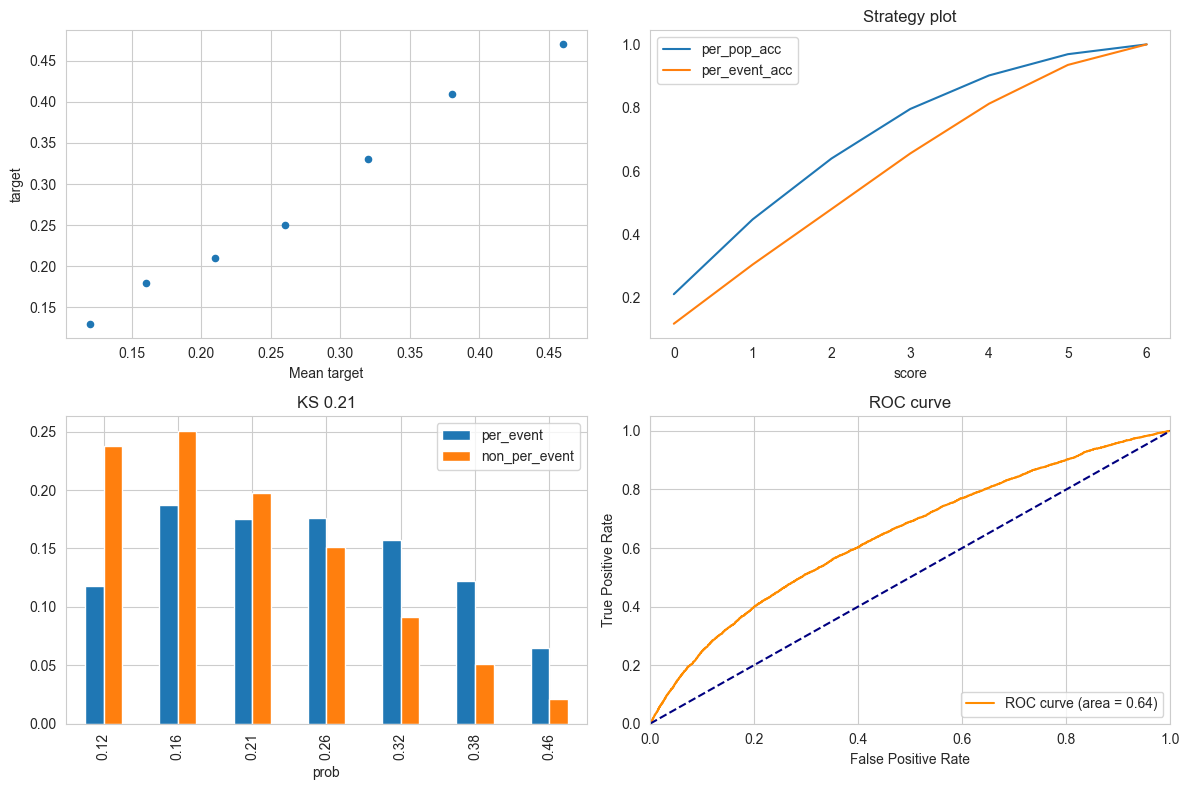

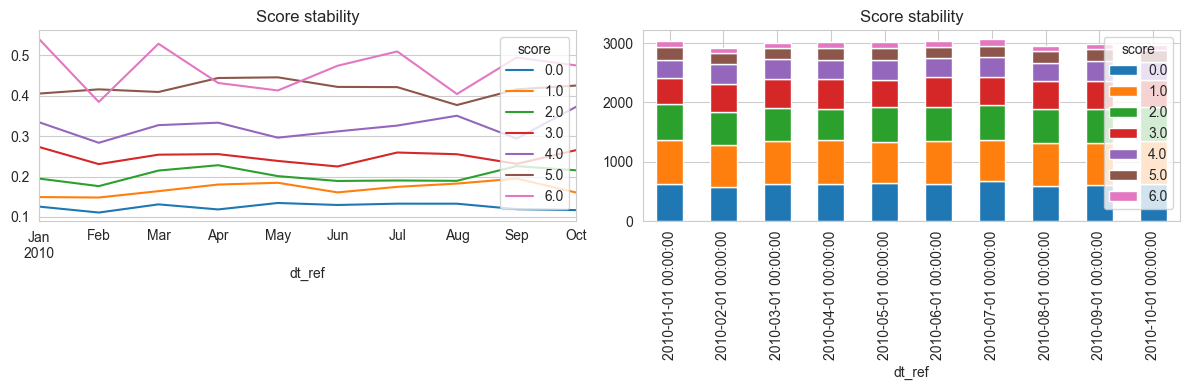

,score_1,score_2,p_value_test,cv_1,per_invertion
0,0,1,0.00001,0.062376,0.0
1,1,2,0.00016,0.088202,0.0
2,2,3,0.00008,0.082096,0.0
3,3,4,0.00000,0.062266,0.0
4,4,5,0.00002,0.080539,0.0
5,5,6,0.03299,0.044328,0.3


CPU times: user 3.55 s, sys: 1.71 s, total: 5.26 s
Wall time: 1.96 s


In [60]:
%%time
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=0.2,random_state=42, max_iter=1000)\
        .fit(df2.query('sample_id < 7')[vars],df2.query('sample_id < 7')['target'])

df = (
    df.assign(
        prob=logit_res.predict(df2),
        score=lambda x:createCluster(x, n_bins=7)
    )
)

display(HTML("<h2>Model with %s </h2>"% clf.__class__.__name__))
model_report(df,'sample_id >= 7 ')

,score,prob,target,count,event,non_event,per_count,per_event,non_per_event,odds,per_pop_acc,per_event_acc,lift
0,0.0,0.11,0.09,1513.0,141.0,1372.0,0.13,0.05,0.15,0.35,0.13,0.05,0.40
1,1.0,0.14,0.17,2395.0,404.0,1991.0,0.20,0.15,0.21,0.70,0.33,0.20,0.76
2,2.0,0.18,0.19,1882.0,361.0,1521.0,0.16,0.13,0.16,0.82,0.48,0.34,0.84
3,3.0,0.21,0.21,1693.0,353.0,1340.0,0.14,0.13,0.14,0.91,0.62,0.47,0.93
4,4.0,0.25,0.22,1427.0,316.0,1111.0,0.12,0.12,0.12,0.98,0.74,0.58,0.98
5,5.0,0.29,0.31,1007.0,311.0,696.0,0.08,0.12,0.08,1.54,0.83,0.70,1.38
6,6.0,0.33,0.35,840.0,295.0,545.0,0.07,0.11,0.06,1.86,0.90,0.81,1.55
7,7.0,0.37,0.41,593.0,242.0,351.0,0.05,0.09,0.04,2.37,0.95,0.90,1.82
8,8.0,0.42,0.41,417.0,172.0,245.0,0.03,0.06,0.03,2.42,0.98,0.96,1.82
9,9.0,0.49,0.49,207.0,101.0,106.0,0.02,0.04,0.01,3.28,1.00,1.00,2.18


,prob,target,count,event,non_event,per_count,per_event,non_per_event,odds,per_pop_acc,per_event_acc,lift
0,0.28,0.28,1197.4,269.6,927.8,0.1,0.1,0.1,1.52,0.7,0.6,1.27


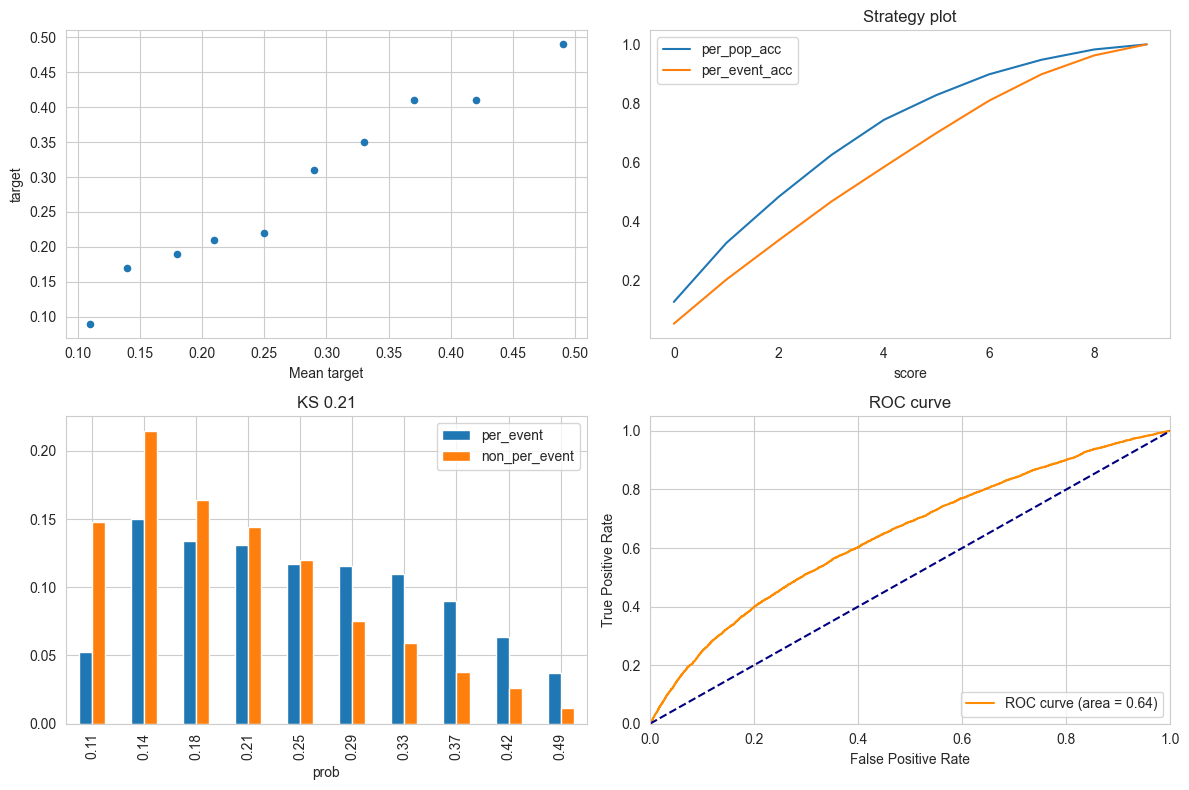

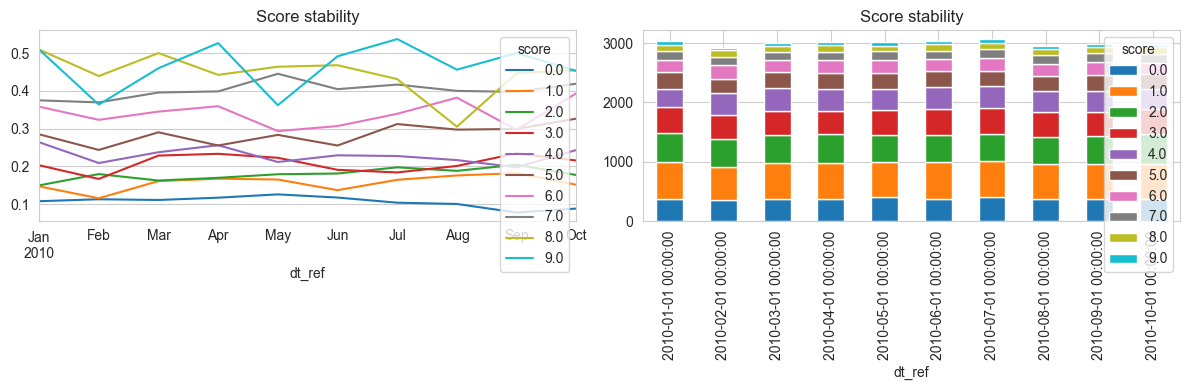

,score_1,score_2,p_value_test,cv_1,per_invertion
0,0,1,0.00033,0.128140,0.0
1,1,2,0.00743,0.118768,0.0
2,2,3,0.01153,0.084505,0.2
3,3,4,0.04530,0.103774,0.2
4,4,5,0.00057,0.088074,0.1
5,5,6,0.00065,0.088091,0.1
6,6,7,0.00149,0.096570,0.0
7,7,8,0.04957,0.051154,0.1
8,8,9,0.45591,0.118418,0.4


CPU times: user 9.24 s, sys: 1.19 s, total: 10.4 s
Wall time: 7.85 s


In [61]:
%%time
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=[20], random_state=42)\
        .fit(df2.query('sample_id < 7')[vars],df2.query('sample_id < 7')['target'])

df = (
    df.assign(
        prob=logit_res.predict(df2),
        score=lambda x:createCluster(x)
    )
)

display(HTML("<h2>Model with %s </h2>"% clf.__class__.__name__))
model_report(df,'sample_id >= 7 ')

,score,prob,target,count,event,non_event,per_count,per_event,non_per_event,odds,per_pop_acc,per_event_acc,lift
0,0.0,0.12,0.13,2525.0,317.0,2208.0,0.21,0.12,0.24,0.49,0.21,0.12,0.58
1,1.0,0.16,0.18,2829.0,504.0,2325.0,0.24,0.19,0.25,0.75,0.45,0.30,0.80
2,2.0,0.21,0.21,2302.0,472.0,1830.0,0.19,0.18,0.20,0.89,0.64,0.48,0.93
3,3.0,0.26,0.25,1875.0,474.0,1401.0,0.16,0.18,0.15,1.16,0.80,0.66,1.11
4,4.0,0.32,0.33,1268.0,424.0,844.0,0.11,0.16,0.09,1.73,0.90,0.81,1.47
5,5.0,0.38,0.41,804.0,330.0,474.0,0.07,0.12,0.05,2.40,0.97,0.94,1.82
6,6.0,0.46,0.47,371.0,175.0,196.0,0.03,0.06,0.02,3.07,1.00,1.00,2.09


,prob,target,count,event,non_event,per_count,per_event,non_per_event,odds,per_pop_acc,per_event_acc,lift
0,0.27,0.28,1710.57,385.14,1325.43,0.14,0.14,0.14,1.5,0.71,0.61,1.26


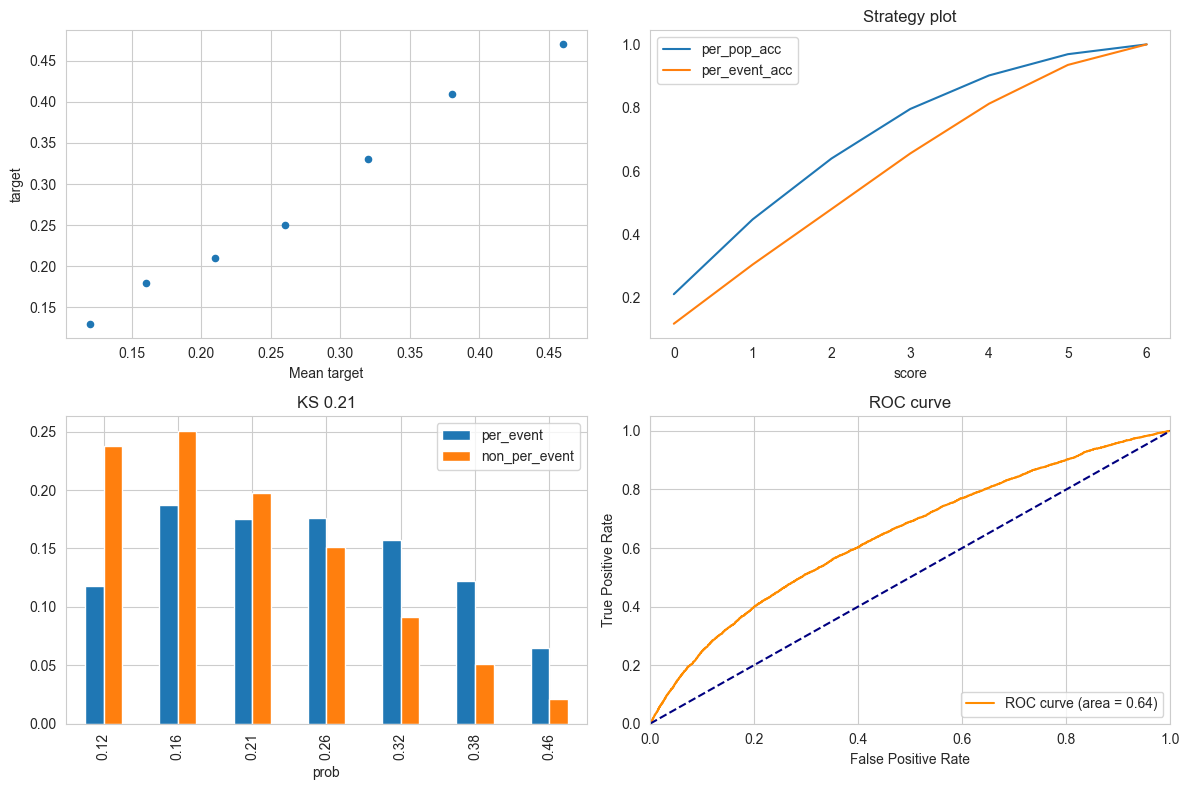

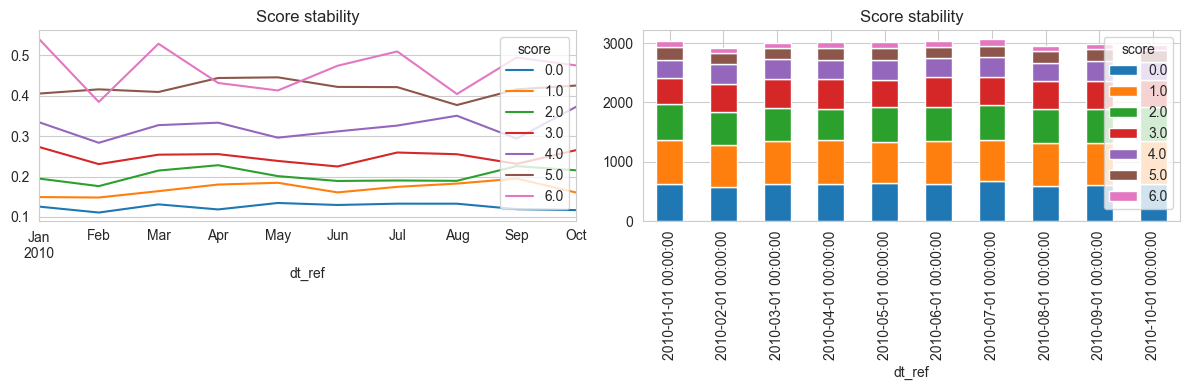

,score_1,score_2,p_value_test,cv_1,per_invertion
0,0,1,0.00001,0.062376,0.0
1,1,2,0.00016,0.088202,0.0
2,2,3,0.00008,0.082096,0.0
3,3,4,0.00000,0.062266,0.0
4,4,5,0.00002,0.080539,0.0
5,5,6,0.03299,0.044328,0.3


CPU times: user 3.33 s, sys: 1.07 s, total: 4.4 s
Wall time: 1.94 s


In [62]:
%%time
from sklearn.tree import DecisionTreeClassifier, plot_tree

clf = DecisionTreeClassifier(
        criterion='entropy',
        min_samples_split=0.05,
        #max_depth=4,
        max_leaf_nodes=20,
        random_state=42)\
        .fit(df2.query('sample_id < 7')[vars],df2.query('sample_id < 7')['target'])

df = (
    df.assign(
        prob=logit_res.predict(df2),
        score=lambda x:createCluster(x, n_bins=7)
    )
)

display(HTML("<h2>Model with %s </h2>"% clf.__class__.__name__))
model_report(df,'sample_id >= 7 ')

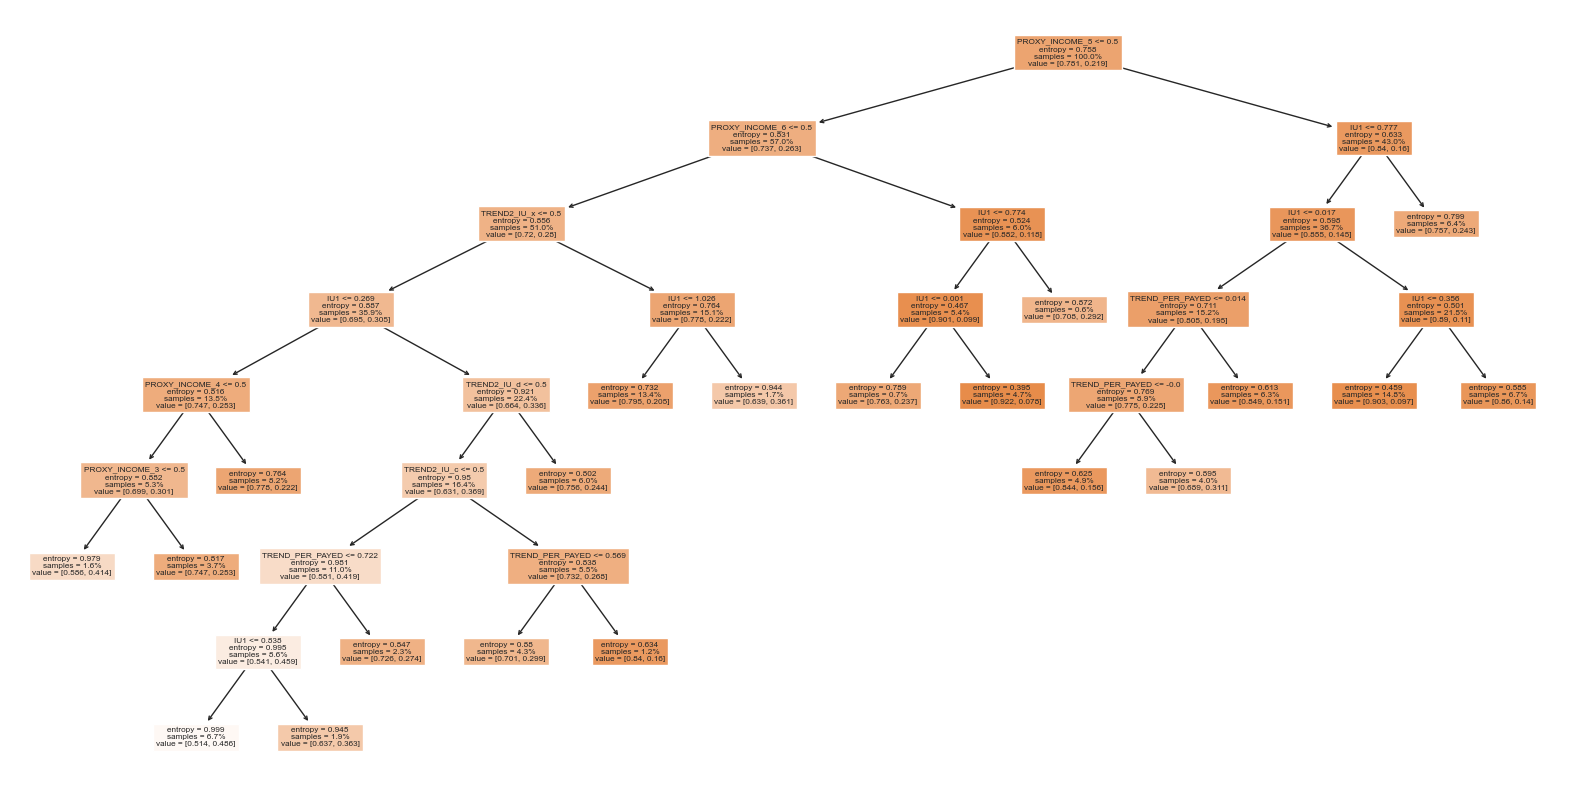

In [63]:
plt.figure(figsize=(20,10))
plot_tree(clf,filled=True,proportion=True, feature_names=vars);

,score,prob,target,count,event,non_event,per_count,per_event,non_per_event,odds,per_pop_acc,per_event_acc,lift
0,0.0,0.11,0.09,1513.0,141.0,1372.0,0.13,0.05,0.15,0.35,0.13,0.05,0.40
1,1.0,0.14,0.17,2395.0,404.0,1991.0,0.20,0.15,0.21,0.70,0.33,0.20,0.76
2,2.0,0.18,0.19,1882.0,361.0,1521.0,0.16,0.13,0.16,0.82,0.48,0.34,0.84
3,3.0,0.21,0.21,1693.0,353.0,1340.0,0.14,0.13,0.14,0.91,0.62,0.47,0.93
4,4.0,0.25,0.22,1427.0,316.0,1111.0,0.12,0.12,0.12,0.98,0.74,0.58,0.98
5,5.0,0.29,0.31,1007.0,311.0,696.0,0.08,0.12,0.08,1.54,0.83,0.70,1.38
6,6.0,0.33,0.35,840.0,295.0,545.0,0.07,0.11,0.06,1.86,0.90,0.81,1.55
7,7.0,0.37,0.41,593.0,242.0,351.0,0.05,0.09,0.04,2.37,0.95,0.90,1.82
8,8.0,0.42,0.41,417.0,172.0,245.0,0.03,0.06,0.03,2.42,0.98,0.96,1.82
9,9.0,0.49,0.49,207.0,101.0,106.0,0.02,0.04,0.01,3.28,1.00,1.00,2.18


,prob,target,count,event,non_event,per_count,per_event,non_per_event,odds,per_pop_acc,per_event_acc,lift
0,0.28,0.28,1197.4,269.6,927.8,0.1,0.1,0.1,1.52,0.7,0.6,1.27


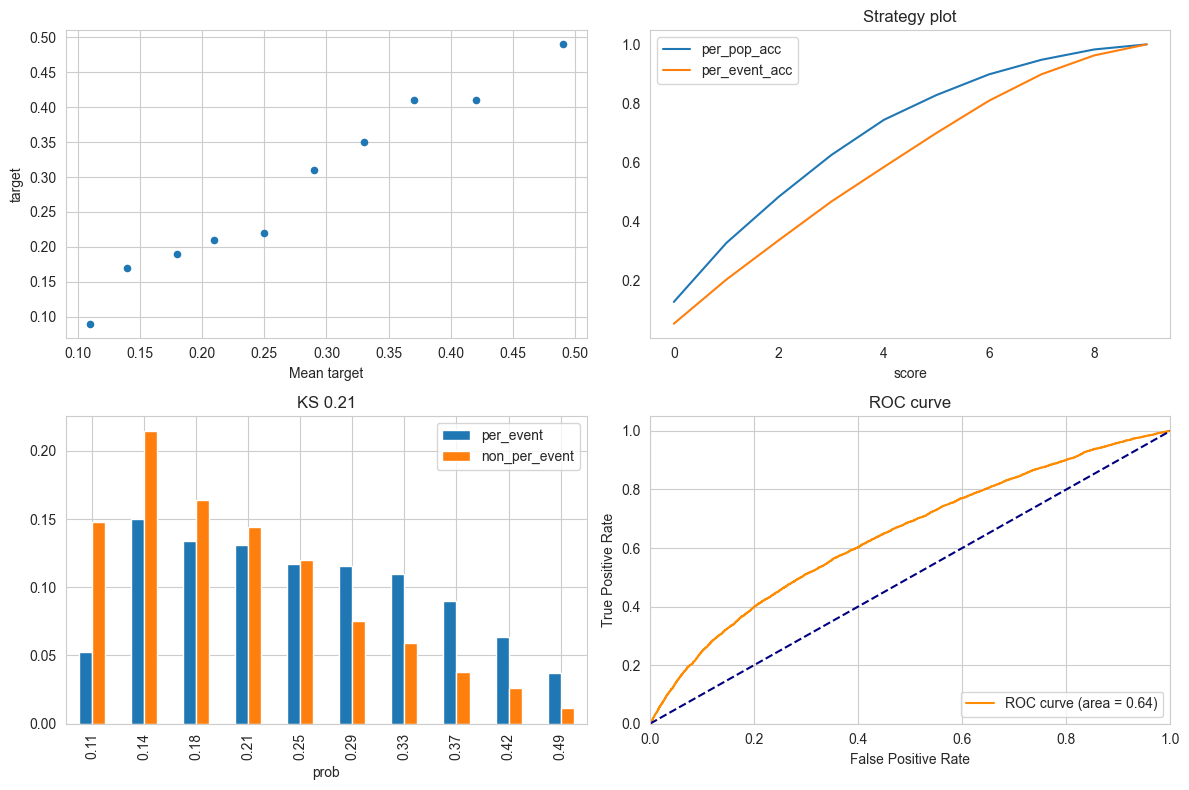

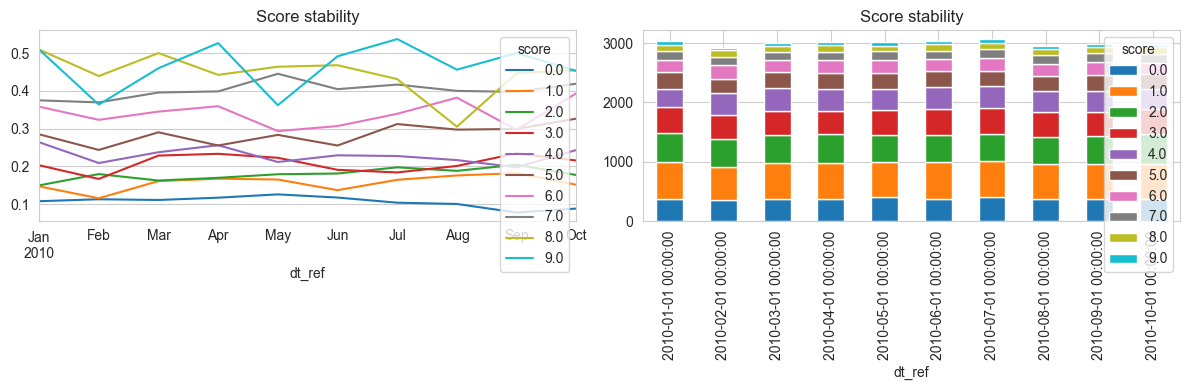

,score_1,score_2,p_value_test,cv_1,per_invertion
0,0,1,0.00033,0.128140,0.0
1,1,2,0.00743,0.118768,0.0
2,2,3,0.01153,0.084505,0.2
3,3,4,0.04530,0.103774,0.2
4,4,5,0.00057,0.088074,0.1
5,5,6,0.00065,0.088091,0.1
6,6,7,0.00149,0.096570,0.0
7,7,8,0.04957,0.051154,0.1
8,8,9,0.45591,0.118418,0.4


CPU times: user 8.48 s, sys: 8.14 s, total: 16.6 s
Wall time: 4.35 s


In [64]:
%%time
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier

clf = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=30, random_state=42)\
     .fit(df2.query('sample_id < 7')[vars],df2.query('sample_id < 7')['target'])

df = (
    df.assign(
        prob=logit_res.predict(df2),
        score=lambda x:createCluster(x)
    )
)

display(HTML("<h2>Model with %s </h2>"% clf.__class__.__name__))
model_report(df,'sample_id >= 7 ')

,score,prob,target,count,event,non_event,per_count,per_event,non_per_event,odds,per_pop_acc,per_event_acc,lift
0,0.0,0.12,0.13,2525.0,317.0,2208.0,0.21,0.12,0.24,0.49,0.21,0.12,0.58
1,1.0,0.16,0.18,2829.0,504.0,2325.0,0.24,0.19,0.25,0.75,0.45,0.30,0.80
2,2.0,0.21,0.21,2302.0,472.0,1830.0,0.19,0.18,0.20,0.89,0.64,0.48,0.93
3,3.0,0.26,0.25,1875.0,474.0,1401.0,0.16,0.18,0.15,1.16,0.80,0.66,1.11
4,4.0,0.32,0.33,1268.0,424.0,844.0,0.11,0.16,0.09,1.73,0.90,0.81,1.47
5,5.0,0.38,0.41,804.0,330.0,474.0,0.07,0.12,0.05,2.40,0.97,0.94,1.82
6,6.0,0.46,0.47,371.0,175.0,196.0,0.03,0.06,0.02,3.07,1.00,1.00,2.09


,prob,target,count,event,non_event,per_count,per_event,non_per_event,odds,per_pop_acc,per_event_acc,lift
0,0.27,0.28,1710.57,385.14,1325.43,0.14,0.14,0.14,1.5,0.71,0.61,1.26


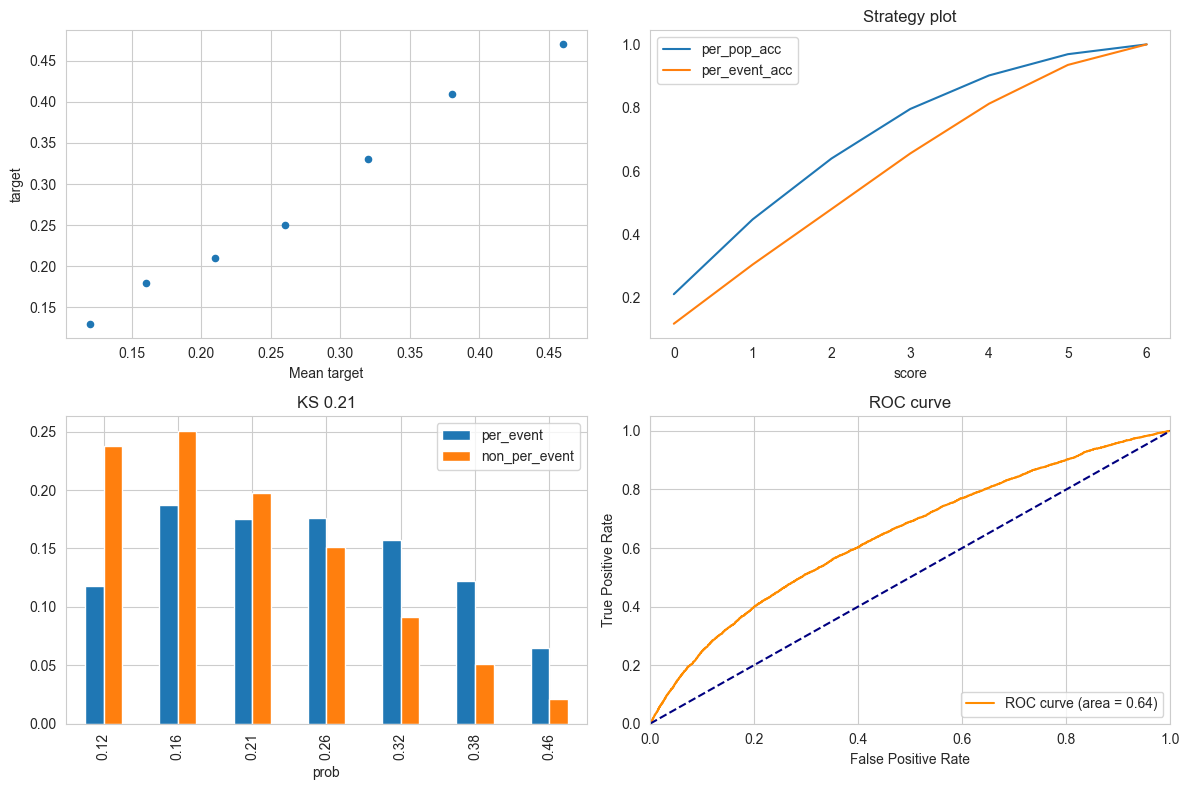

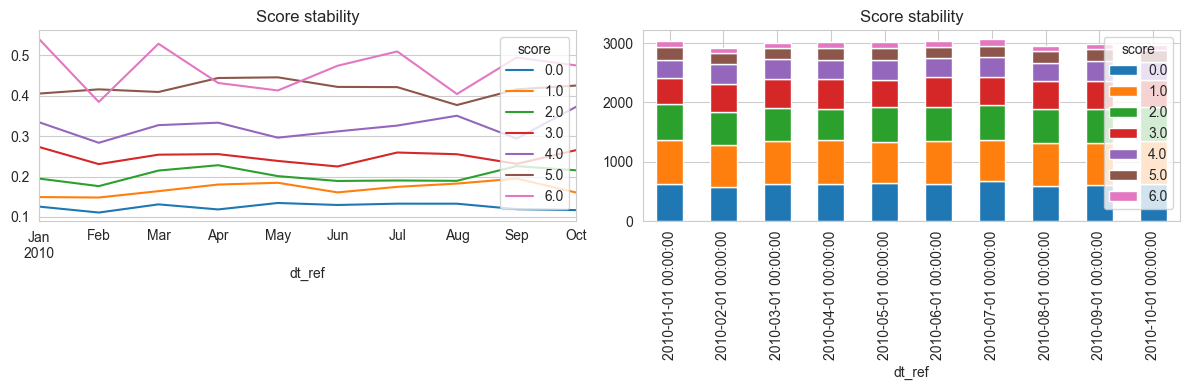

,score_1,score_2,p_value_test,cv_1,per_invertion
0,0,1,0.00001,0.062376,0.0
1,1,2,0.00016,0.088202,0.0
2,2,3,0.00008,0.082096,0.0
3,3,4,0.00000,0.062266,0.0
4,4,5,0.00002,0.080539,0.0
5,5,6,0.03299,0.044328,0.3


CPU times: user 7.35 s, sys: 1.96 s, total: 9.31 s
Wall time: 2.7 s


In [65]:
%%time
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier

clf = HistGradientBoostingClassifier(min_samples_leaf=5,random_state=42)\
         .fit(df2.query('sample_id < 7')[vars],df2.query('sample_id < 7')['target'])

df = (
    df.assign(
        prob=logit_res.predict(df2),
        score=lambda x:createCluster(x,n_bins=7)
    )
)

display(HTML("<h2>Model with %s </h2>"% clf.__class__.__name__))
model_report(df,'sample_id >= 7 ')

In [66]:
(
    df
    .pivot_table(index='score',columns='PROXY_INCOME',values='BILL_AMT1')
    .fillna(0)
    .apply(lambda x:x/x.sum())
    .round(2)
    .style.background_gradient()
)

PROXY_INCOME,2,3,4,5,6
score,,,,,
0.0,0.000000,0.000000,0.030000,0.080000,0.160000
1.0,0.000000,0.070000,0.100000,0.100000,0.200000
2.0,0.090000,0.160000,0.140000,0.130000,0.210000
3.0,0.190000,0.190000,0.170000,0.150000,0.430000
4.0,0.210000,0.200000,0.150000,0.210000,0.000000
5.0,0.260000,0.160000,0.170000,0.310000,0.000000
6.0,0.250000,0.210000,0.230000,0.000000,0.000000


In [67]:
# trying to understand the behaviour of sensible variables.
(
    df
    .copy()
    .assign(isMale=lambda x:x['SEX']==1)
    .groupby('score')
    .agg(
        mean_age     = ('AGE','mean'),
        max_age     = ('AGE','max'),
        per_male     = ('isMale','mean'),
        per_MARRIED  = ('MARRIED','mean'),
        target       = ('target','mean'),
    )
    .astype({'mean_age':'int'})
    .round(2)
    .style.background_gradient(axis=0)
)

,mean_age,max_age,per_male,per_MARRIED,target
score,,,,,
0.0,34,70,0.250000,0.310000,0.130000
1.0,36,75,0.380000,0.550000,0.170000
2.0,34,79,0.370000,0.410000,0.200000
3.0,35,75,0.460000,0.500000,0.250000
4.0,35,70,0.510000,0.470000,0.320000
5.0,35,73,0.530000,0.530000,0.420000
6.0,37,73,0.670000,0.600000,0.470000
